In [1]:
# dataset - /content/insurance.csv

In [2]:
# --- 1.Import & Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# --- 2.Data Loading & Cleaning ---
df = pd.read_csv('/content/insurance.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [4]:
# --- 3.Encode categorical variables ---
for col in ['sex', 'smoker', 'region']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

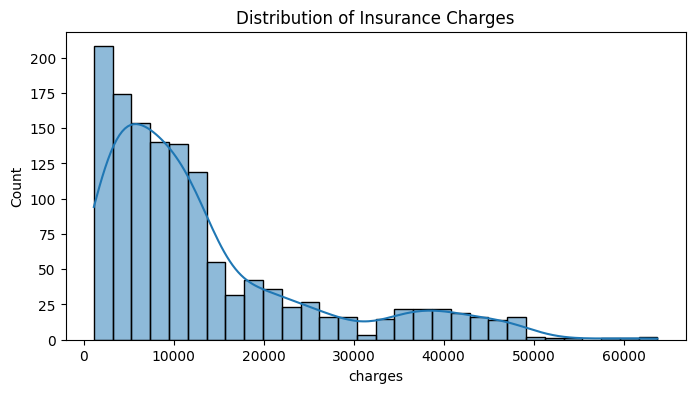

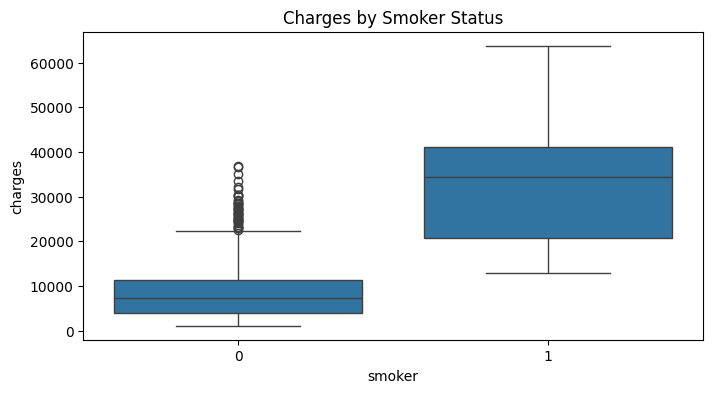

In [6]:
# --- 4.Exploratory Data Analysis (EDA) ---
plt.figure(figsize=(8,4))
sns.histplot(df['charges'], bins=30, kde=True)
plt.title('Distribution of Insurance Charges')
plt.show()


plt.figure(figsize=(8,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoker Status')
plt.show()

In [8]:
# --- 5.Feature & Target Setup ---
X = df.drop('charges', axis=1)
y = df['charges']

# Transform target to improve normality
pt = PowerTransformer()
y_trans = pt.fit_transform(y.values.reshape(-1,1)).flatten()

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# --- 6.Model Training & Evaluation ---
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2 Score': r2, 'MSE': mse}
    print(f"{name}: R2 = {r2:.3f}, MSE = {mse:.3f}")

Linear Regression: R2 = 0.805, MSE = 0.207
Ridge Regression: R2 = 0.805, MSE = 0.207
Lasso Regression: R2 = 0.803, MSE = 0.210
Random Forest: R2 = 0.850, MSE = 0.160
Gradient Boosting: R2 = 0.867, MSE = 0.141


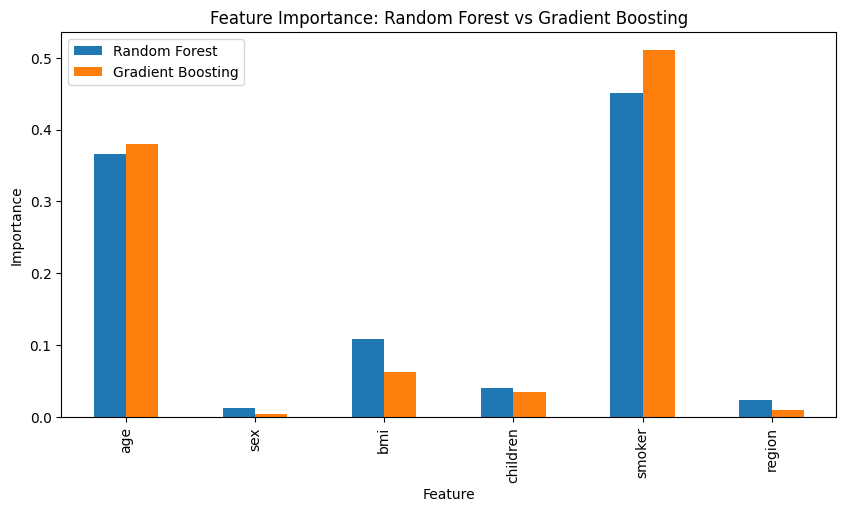

In [10]:
# --- 7.Feature Importance for Tree Models ---
rf = models['Random Forest']
gb = models['Gradient Boosting']
features = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Random Forest': rf.feature_importances_,
    'Gradient Boosting': gb.feature_importances_
})

feat_imp_df.plot(x='Feature', kind='bar', figsize=(10,5))
plt.title('Feature Importance: Random Forest vs Gradient Boosting')
plt.ylabel('Importance')
plt.show()

In [11]:
# --- Predict and Inverse Transform for Comparison ---
best_model = gb
y_pred_trans = best_model.predict(X_test_scaled)
y_pred_final = pt.inverse_transform(y_pred_trans.reshape(-1,1)).flatten()
y_test_final = pt.inverse_transform(y_test.reshape(-1,1)).flatten()

print(f"Final RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.2f}")
print(f"Final R2 Score: {r2_score(y_test_final, y_pred_final):.2f}")

Final RMSE: 4416.62
Final R2 Score: 0.87


In [12]:
df_results = pd.DataFrame({'Actual': y_test_final, 'Predicted': y_pred_final})
df_results.to_csv('insurance_predictions_gb.csv', index=False)